In [ ]:
import h5py
import numpy as np
import json
from PIL import Image
from io import BytesIO
import zipfile
import glob
from tqdm import tqdm
import os
import time

In [ ]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!mkdir /content/dataset

mkdir: cannot create directory ‘/content/dataset’: File exists


In [ ]:
# class DatasetToHDF5:
#     def __init__(self, image_zip_dir, label_zip_dir, hdf5_file, max_retries=5, initial_wait_seconds=1):
#         self.image_zip_dir = image_zip_dir
#         self.label_zip_dir = label_zip_dir
#         self.hdf5_file = hdf5_file
#         self.max_retries = max_retries
#         self.initial_wait_seconds = initial_wait_seconds

#     def _open_with_retry(self, zip_file, file_name):
#         retries = 0
#         wait_seconds = self.initial_wait_seconds
#         while retries < self.max_retries:
#             try:
#                 with zip_file.open(file_name) as file:
#                     return BytesIO(file.read())
#             except OSError as e:
#                 print(f"OSError [Errno {e.errno}] encountered. Retrying {file_name}...")
#                 time.sleep(wait_seconds)
#                 wait_seconds *= 2
#                 retries += 1
#         raise Exception(f"Failed to open {file_name} after {self.max_retries} attempts.")

#     def convert(self):
#         with h5py.File(self.hdf5_file, 'w') as hf:
#             grp_image = hf.create_group('image')
#             grp_age = hf.create_group('age')
#             grp_box = hf.create_group('box')

#             image_zips = glob.glob(os.path.join(self.image_zip_dir, '*.zip'))
#             label_zips = glob.glob(os.path.join(self.label_zip_dir, '*.zip'))

#             for image_zip_path in tqdm(image_zips, desc='Processing Image Zips'):
#                 with zipfile.ZipFile(image_zip_path, 'r') as img_zf:
#                     for img_filename in img_zf.namelist():
#                         img_file = self._open_with_retry(img_zf, img_filename)
#                         img = Image.open(img_file)
#                         img_arr = np.array(img)
#                         img_name = os.path.splitext(os.path.basename(img_filename))[0].upper()
#                         grp_image.create_dataset(img_name, data=img_arr, compression="gzip", compression_opts=5)

#             for label_zip_path in tqdm(label_zips, desc='Processing Label Zips'):
#                 with zipfile.ZipFile(label_zip_path, 'r') as label_zf:
#                     for label_filename in label_zf.namelist():
#                         label_file = self._open_with_retry(label_zf, label_filename)
#                         label_data = json.load(label_file)
#                         label_name = os.path.splitext(os.path.basename(label_filename))[0].upper()

#                         # 나이
#                         grp_age.create_dataset(label_name, data=np.array(label_data['age_past']))
#                         # 바운딩 박스
#                         box_data = label_data['annotation'][0]['box']
#                         box_arr = np.array([box_data['x'], box_data['y'], box_data['w'], box_data['h']])
#                         grp_box.create_dataset(label_name, data=box_arr)


In [ ]:
!cp /content/drive/MyDrive/DL_DATA/DL_Face_REC/data_age_train.hdf5 /content/dataset

In [ ]:
class DatasetToHDF5:
    def __init__(self, image_zip_dir, label_zip_dir, hdf5_file, max_retries=5, initial_wait_seconds=1):
        self.image_zip_dir = image_zip_dir
        self.label_zip_dir = label_zip_dir
        self.hdf5_file = hdf5_file
        self.max_retries = max_retries
        self.initial_wait_seconds = initial_wait_seconds

    def _open_with_retry(self, zip_file, file_name):
        retries = 0
        wait_seconds = self.initial_wait_seconds
        while retries < self.max_retries:
            try:
                with zip_file.open(file_name) as file:
                    return BytesIO(file.read())
            except OSError as e:
                print(f"OSError [Errno {e.errno}] encountered. Retrying {file_name}...")
                time.sleep(wait_seconds)
                wait_seconds *= 2
                retries += 1
        raise Exception(f"Failed to open {file_name} after {self.max_retries} attempts.")

    def process_images(self):
        with h5py.File(self.hdf5_file, 'a') as hf:
            if 'image' not in hf:
                grp_image = hf.create_group('image')
            else:
                grp_image = hf['image']

            image_zips = glob.glob(os.path.join(self.image_zip_dir, '*.zip'))
            for image_zip_path in tqdm(image_zips, desc='Processing Image Zips'):
                with zipfile.ZipFile(image_zip_path, 'r') as img_zf:
                    for img_filename in img_zf.namelist():
                        img_file = self._open_with_retry(img_zf, img_filename)
                        img = Image.open(img_file)
                        img_arr = np.array(img)
                        img_name = os.path.splitext(os.path.basename(img_filename))[0].upper()
                        if img_name not in grp_image:
                            grp_image.create_dataset(img_name, data=img_arr, compression="gzip", compression_opts=5)

    def process_labels(self):
        with h5py.File(self.hdf5_file, 'a') as hf:
            grp_age = hf.require_group('age')
            grp_box = hf.require_group('box')

            label_zips = glob.glob(os.path.join(self.label_zip_dir, '*.zip'))
            for label_zip_path in tqdm(label_zips, desc='Processing Label Zips'):
                with zipfile.ZipFile(label_zip_path, 'r') as label_zf:
                    for label_filename in label_zf.namelist():
                        label_file = self._open_with_retry(label_zf, label_filename)
                        label_data = json.load(label_file)
                        # 파일 이름을 대문자로 변환
                        label_name = os.path.splitext(os.path.basename(label_filename))[0].upper()

                        # 나이 데이터 처리
                        if label_name not in grp_age:
                            age_data = np.array(label_data['age_past'], dtype=np.int8)
                            grp_age.create_dataset(label_name, data=age_data)
                        else:
                            print(f"Age data for {label_name} already exists")

                        # 바운딩 박스 데이터 처리
                        if label_name not in grp_box:
                            box_data = label_data['annotation'][0]['box']
                            box_arr = np.array([box_data['x'], box_data['y'], box_data['w'], box_data['h']], dtype=np.int16)
                            grp_box.create_dataset(label_name, data=box_arr)
                        else:
                            print(f"Box data for {label_name} already exists")

In [ ]:
image_zip_dir = '/content/drive/Othercomputers/Home/data_age/data/Training/image'
label_zip_dir = '/content/drive/Othercomputers/Home/data_age/data/Training/label'
hdf5_file = '/content/dataset/data_age_train.hdf5'

converter = DatasetToHDF5(image_zip_dir, label_zip_dir, hdf5_file)
converter.process_labels()

Processing Label Zips: 100%|██████████| 803/803 [00:56<00:00, 14.26it/s]


In [ ]:
!ls -hl /content/dataset/

total 89G
-rw------- 1 root root 89G Feb 26 12:52 data_age_train.hdf5


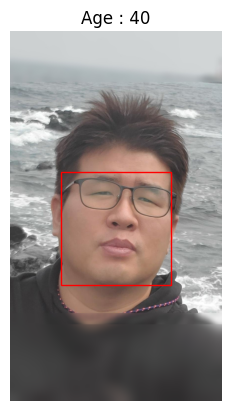

In [ ]:
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches

# HDF5 파일 열기
file_path = '/content/dataset/data_age_train.hdf5'

with h5py.File(file_path, 'r') as file:
    keys = list(file['image'].keys())
    random_key = random.choice(keys)
    image_data = file['image'][random_key][:]
    label_data = file['age'][random_key][()]
    box = file['box'][random_key][()]
    plt.imshow(image_data)
    rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.axis('off')
    plt.title(f'Age : {label_data}')
    plt.show()


In [ ]:
!cp /content/dataset/data_age_train.hdf5 /content/drive/MyDrive/DL_DATA/DL_Face_REC/

In [ ]:
!ls -hl /content/drive/MyDrive/DL_DATA/DL_Face_REC/

total 89G
-rw------- 1 root root  89G Feb 26 13:25 data_age_train.hdf5
-rw------- 1 root root 909K Feb 19 12:39 haarcascade_frontalface_default.xml
drwx------ 4 root root 4.0K Feb 19 14:11 Model


In [ ]:
image_zip_dir = '/content/drive/Othercomputers/Home/data_age/data/Validation/image'
label_zip_dir = '/content/drive/Othercomputers/Home/data_age/data/Validation/label'
hdf5_file = '/content/dataset/data_age_val.hdf5'

converter = DatasetToHDF5(image_zip_dir, label_zip_dir, hdf5_file)
converter.process_images()

Processing Image Zips: 100%|██████████| 101/101 [49:17<00:00, 29.29s/it]


In [ ]:
!ls -hl /content/dataset/

total 99G
-rw------- 1 root root 89G Feb 26 12:52 data_age_train.hdf5
-rw-r--r-- 1 root root 11G Feb 26 14:17 data_age_val.hdf5


In [ ]:
image_zip_dir = '/content/drive/Othercomputers/Home/data_age/data/Validation/image'
label_zip_dir = '/content/drive/Othercomputers/Home/data_age/data/Validation/label'
hdf5_file = '/content/dataset/data_age_val.hdf5'

converter = DatasetToHDF5(image_zip_dir, label_zip_dir, hdf5_file)
converter.process_labels()

Processing Label Zips: 100%|██████████| 101/101 [00:07<00:00, 12.99it/s]


In [ ]:
!cp /content/dataset/data_age_val.hdf5 /content/drive/MyDrive/DL_DATA/DL_Face_REC/

In [ ]:
!ls -hl /content/drive/MyDrive/DL_DATA/DL_Face_REC/

total 99G
-rw------- 1 root root  89G Feb 26 13:25 data_age_train.hdf5
-rw------- 1 root root  11G Feb 26 14:21 data_age_val.hdf5
-rw------- 1 root root 909K Feb 19 12:39 haarcascade_frontalface_default.xml
drwx------ 4 root root 4.0K Feb 19 14:11 Model


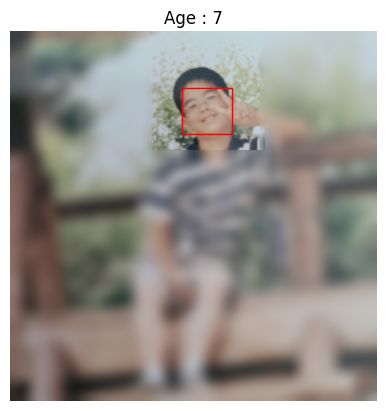

In [ ]:
file_path = '/content/dataset/data_age_val.hdf5'

with h5py.File(file_path, 'r') as file:
    keys = list(file['image'].keys())
    random_key = random.choice(keys)
    image_data = file['image'][random_key][:]
    label_data = file['age'][random_key][()]
    box = file['box'][random_key][()]
    plt.imshow(image_data)
    rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.axis('off')
    plt.title(f'Age : {label_data}')
    plt.show()